# Plot loss, training and dev accuracy

## Examine loss, accuracy curves for a particular model

0 days 00:00:25


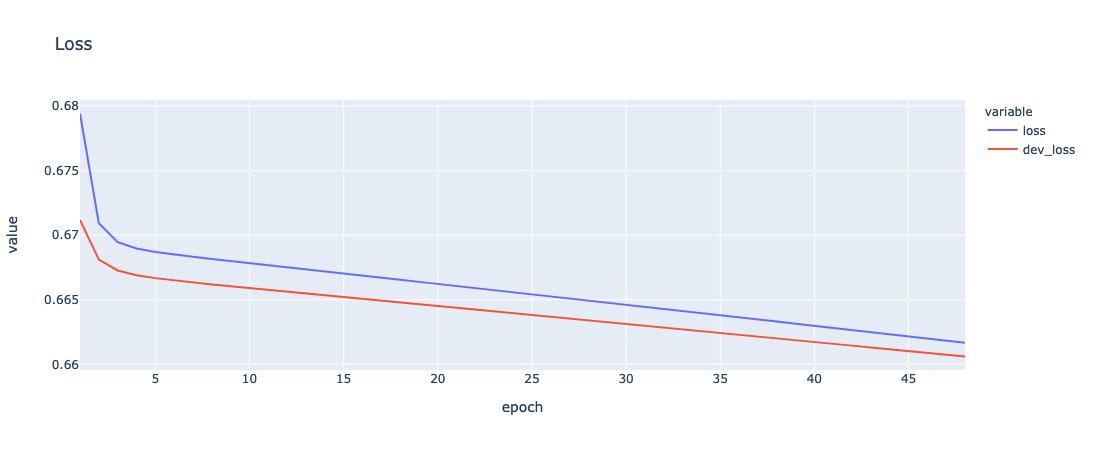

In [14]:
import pandas as pd
modelname = 'cnnmodel2021-04-03_20-39'
log_fpath = f'/projects/tumblr_community_identity/log/{modelname}.csv'
# log = pd.read_csv(log_fpath, parse_dates=[[0, 1]], infer_datetime_format=True)
log = pd.read_csv(log_fpath, parse_dates=['datetime'])
# log

# Calculate time/epoch
log.rename(columns={'date_time': 'datetime'}, inplace=True)
duration = log.datetime.max() - log.datetime.min()
print(duration/log.epoch.max())

# Get last metrics/epoch
# score_cols = ['loss', 'train_accuracy', 'dev_accuracy']
score_cols = ['loss', 'dev_loss']
gped = log.groupby('epoch').agg({col: lambda x: x.tolist()[-1] for col in score_cols})
# gped = gped.iloc[:-1] # for in progress

import plotly.express as px
fig = px.line(gped, x=gped.index, y=['loss', 'dev_loss'], title='Loss')
fig.show()

# fig = px.line(gped, x=gped.index, y=['train_accuracy', 'dev_accuracy'], title='Accuracy')
# fig.show()

## Search for a models

cnnmodel2021-03-29_16-01.csv: 20


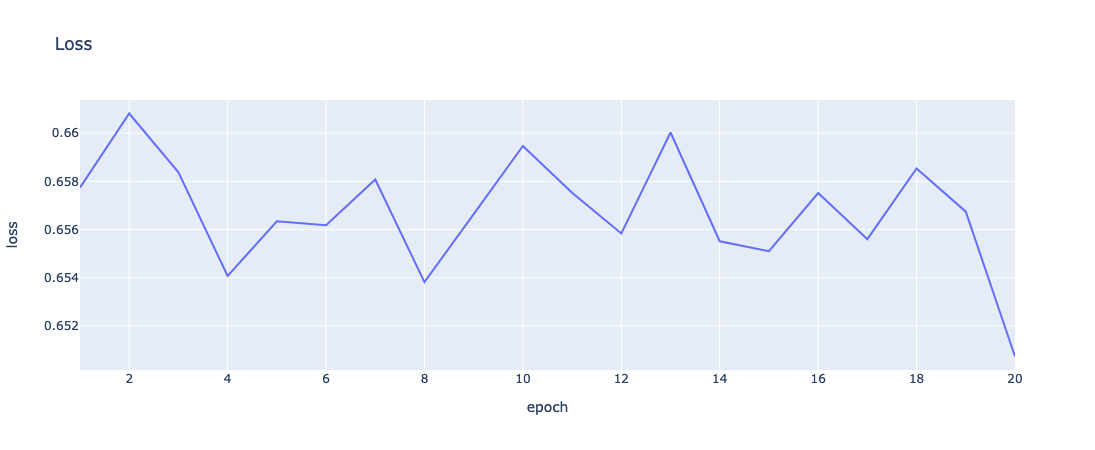

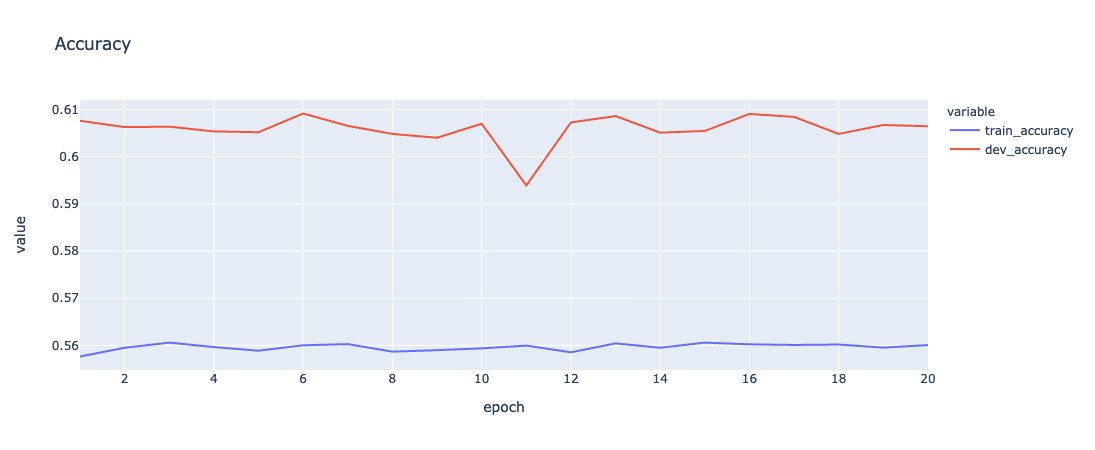

cnnmodel2021-03-29_16-50.csv: 20


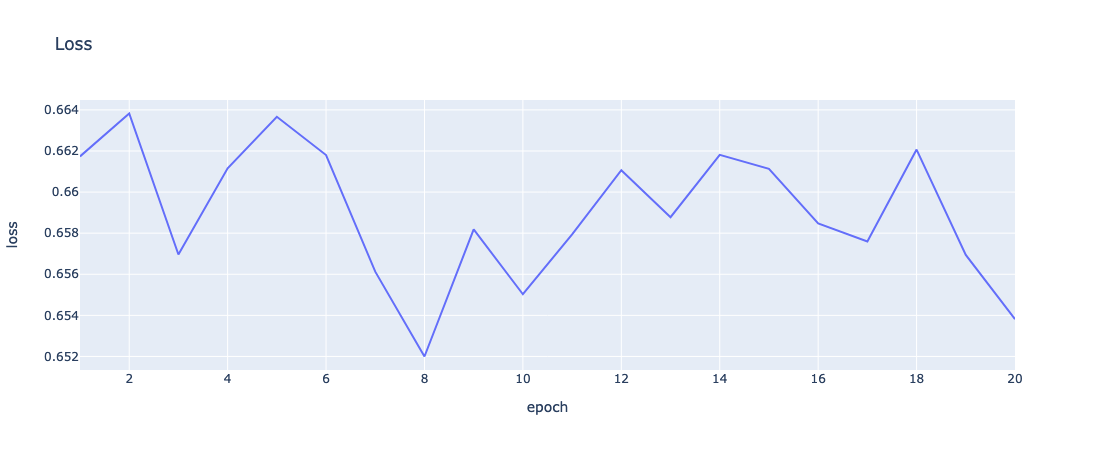

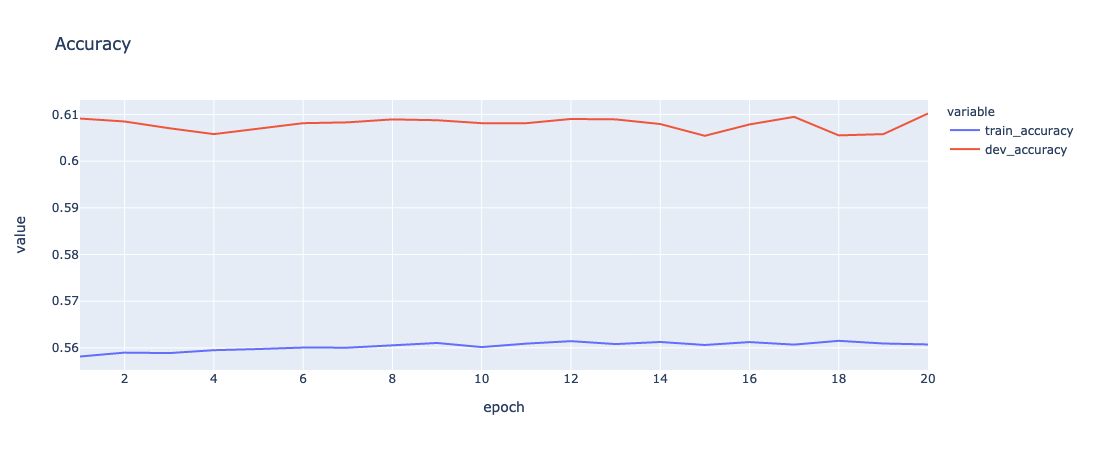

cnnmodel2021-03-29_10-45.csv: 20


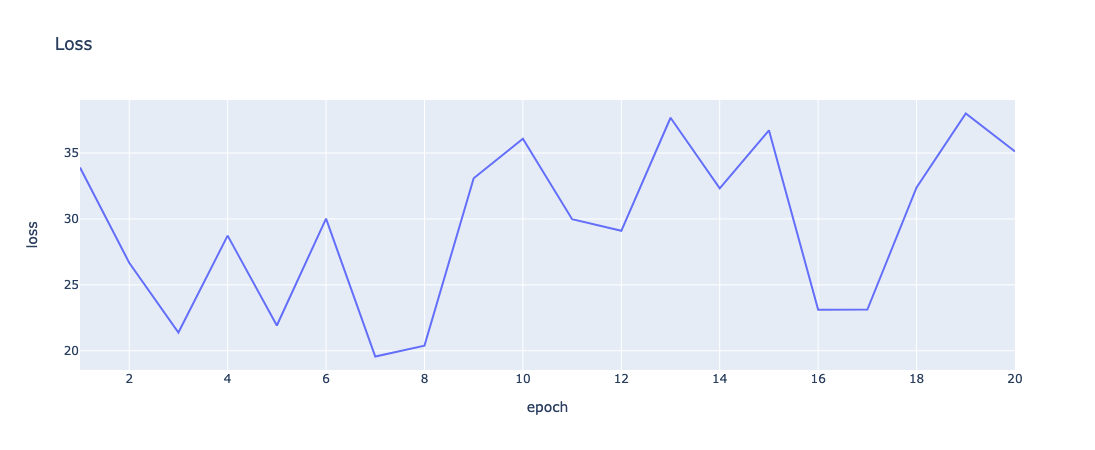

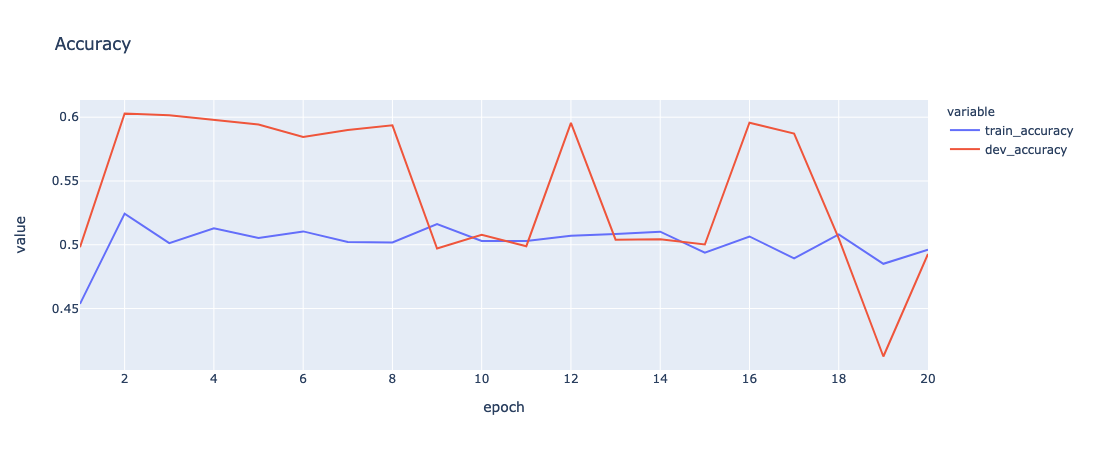

In [24]:
# Search for a model with a decreasing loss
import os

log_dirpath = f'/projects/tumblr_community_identity/log/'
selected_day = '2021-03-29'
for fname in os.listdir(log_dirpath):
    if selected_day in fname:
        log_fpath = os.path.join(log_dirpath, fname)
        log = pd.read_csv(log_fpath, parse_dates=['datetime'])
        if log.epoch.max() == 20:
            print(f'{fname}: {log.epoch.max()}')

            # Get last metrics/epoch
            score_cols = ['loss', 'train_accuracy', 'dev_accuracy']
            gped = log.groupby('epoch').agg({col: lambda x: x.tolist()[-1] for col in score_cols})

            fig = px.line(gped, x=gped.index, y='loss', title='Loss')
            fig.show()
            fig = px.line(gped, x=gped.index, y=['train_accuracy', 'dev_accuracy'], title='Accuracy')
            fig.show()

In [5]:
# Search for a model that was run for many epochs
import pandas as pd
import os

log_dirpath = f'/projects/tumblr_community_identity/log/'
for fname in os.listdir(log_dirpath):
    log_fpath = os.path.join(log_dirpath, fname)
#     log = pd.read_csv(log_fpath, parse_dates=['datetime'])
    log = pd.read_csv(log_fpath)
    if log.epoch.max() > 1:
        print(f'{fname}: {log.epoch.max()}')

model2021-03-28_13-43.csv: 20
model2021-03-28_11-55.csv: 20
model2021-03-04_10-18.csv: 15
model2021-03-03_09-53.csv: 6


# Simpler FFN classification

## From an online example
https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb

In [2]:
import torch.nn

class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()        
            
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output

In [6]:
# CREATE RANDOM DATA POINTS
from sklearn.datasets import make_blobs
import numpy as np

def blob_label(y, label, loc): # assign labels
    target = np.copy(y)
    for l in loc:
        target[y == l] = label
    return target

x_train, y_train = make_blobs(n_samples=40, n_features=2, centers=[(1,1), (1,1)], cluster_std=1.5, shuffle=True)
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(blob_label(y_train, 0, [0]))
y_train = torch.FloatTensor(blob_label(y_train, 1, [1,2,3]))

x_test, y_test = make_blobs(n_samples=10, n_features=2, cluster_std=1.5, shuffle=True)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(blob_label(y_test, 0, [0]))
y_test = torch.FloatTensor(blob_label(y_test, 1, [1,2,3]))

print(x_train.shape)
print(y_train.shape)

torch.Size([40, 2])
torch.Size([40])


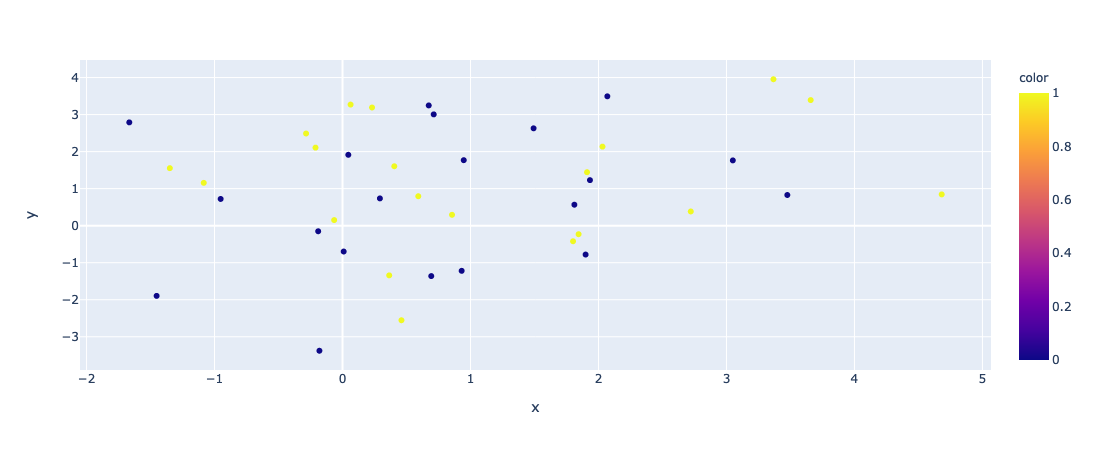

In [7]:
# Plot blobs
import plotly.express as px

fig = px.scatter(x=x_train[:,0], y=x_train[:,1], color=y_train)
fig.show()

In [10]:
# Load in my data
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler

with open('/projects/tumblr_community_identity/tmp/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('/projects/tumblr_community_identity/tmp/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
X_add = X_train[:,np.array(range(60,78))]

scaler = StandardScaler()
X_add_scaled = scaler.fit_transform(X_add)

x_train = torch.FloatTensor(X_add_scaled)
y_train = torch.FloatTensor(y_train)
print(x_train.shape)
print(y_train.shape)

torch.Size([88736, 18])
torch.Size([88736])


In [16]:
from torch.utils.data import Dataset, DataLoader

batch_size = 32

class DatasetMapper(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train = DatasetMapper(x_train, y_train)
loader_train = DataLoader(train, batch_size=batch_size)

In [36]:
# model = Feedforward(2, 10)
model = Feedforward(18, 6) # for my data
criterion = torch.nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.2)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

model.train()
epoch = 100

for epoch in range(epoch):    
    epochloss = 0
    
    for i, (x_batch, y_batch) in enumerate(loader_train):
        optimizer.zero_grad()    # Forward pass
#         y_pred = model(x_train)    # Compute Loss
        y_pred = model(x_batch)    # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        epochloss += loss.item() * x_batch.size(0)
        
        # Backward pass
        loss.backward()
        optimizer.step()

    if i+1 == len(loader_train):
#         print('Epoch {}: train loss: {}'.format(epoch, loss.item()))    
        print('Epoch {}: train loss: {}'.format(epoch, epochloss/len(train)))    
#         Backward pass
#         loss.backward()
#         optimizer.step()

Epoch 0: train loss: 0.7091078726857567
Epoch 1: train loss: 0.6949305541241079
Epoch 2: train loss: 0.6911781647985178
Epoch 3: train loss: 0.68930245034754
Epoch 4: train loss: 0.6879460297893025
Epoch 5: train loss: 0.6868865538752557
Epoch 6: train loss: 0.6860706901834023
Epoch 7: train loss: 0.6853775767655825
Epoch 8: train loss: 0.684799546676124
Epoch 9: train loss: 0.6843130822393209
Epoch 10: train loss: 0.6839173731931142
Epoch 11: train loss: 0.6836162970851055
Epoch 12: train loss: 0.6833697895345128
Epoch 13: train loss: 0.6831664907300339
Epoch 14: train loss: 0.6829993029901192
Epoch 15: train loss: 0.6828602444940726
Epoch 16: train loss: 0.682743914949305
Epoch 17: train loss: 0.6826496312130758
Epoch 18: train loss: 0.6825730869626466
Epoch 19: train loss: 0.6825054074683604
Epoch 20: train loss: 0.6824463940337381
Epoch 21: train loss: 0.6823948841640075
Epoch 22: train loss: 0.6823495683625335
Epoch 23: train loss: 0.6823103217884302
Epoch 24: train loss: 0.682277

In [32]:
model.eval()
y_pred = model(x_test)
before_train = criterion(y_pred.squeeze(), y_test)
print('Test loss before training' , before_train.item())

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x2 and 18x100)

In [25]:
model.eval()
y_pred = model(x_test)
after_train = criterion(y_pred.squeeze(), y_test) 
print('Test loss after Training' , after_train.item())

Test loss after Training 1.1960351467132568


## From my model

In [26]:
# Load in data
import pickle

with open('/projects/tumblr_community_identity/tmp/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('/projects/tumblr_community_identity/tmp/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
print(X_train.shape)
print(y_train.shape)

(88736, 78)
(88736,)


In [27]:
import numpy as np

X_add = X_train[:,np.array(range(60,78))]
X_add.shape

(88736, 18)

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_add_scaled = scaler.fit_transform(X_add)
X_add_scaled[2]

array([-0.00337964, -0.00344965, -0.13135083, -0.06400178, -0.07265849,
       -0.05399981,  0.73113691, -0.14282757, -0.51525502, -0.31324541,
       -0.13302772, -0.05911352, -0.07443967, -0.05304689,  0.73224429,
       -0.14229265, -0.51304759, -0.31760768])

In [12]:
# Try random inputs
import numpy as np

norm = []
for datapt in y_train:
    if datapt == 1:
        norm.append(np.random.normal(loc=0.9, size=(1,18))) 
    else:
        norm.append(np.random.normal(loc=0.1, size=(1,18)))
X_train_n = np.squeeze(np.array(norm))
X_train_n.shape

(88736, 18)

In [3]:
# Try incredibly easy inputs
import numpy as np

norm = []
for datapt in y_train:
    if datapt == 1:
        norm.append(np.ones(18))
    else:
        norm.append(np.zeros(18))
X_train_n = np.squeeze(np.array(norm))
X_train_n.shape

(88736, 18)

In [31]:
y_train.sum()/len(y_train)

0.4998534980165885

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import datetime
import pdb

class FFNTextClassifier(nn.Module):

    def __init__(self):
        super().__init__()
#         self.fc1 = nn.Linear(18, 18)
#         self.fc2 = nn.Linear(18, 9)
#         self.fc3 = nn.Linear(9, 1)
        self.fc1 = nn.Linear(18, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        """ Called indirectly through model(input) """
#         x_add = x[:,np.array(range(60,78))].float()
#         flattened = torch.FloatTensor(x_add.float())
        flattened = torch.FloatTensor(x.float())

        # The "flattened" vector is passed through a fully connected layer
        out = self.fc1(flattened)
        # Activation function is applied
#         out = torch.relu(out)
        out = self.relu(out)

        # The "flattened" vector is passed through a fully connected layer
#         out = self.fc2(out)
#         # Activation function is applied
#         out = torch.relu(out)

#         # The "flattened" vector is passed through a fully connected layer
#         out = self.fc3(out)
#         # Activation function is applied
#         out = torch.relu(out)

        return out.squeeze()

class DatasetMapper(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [14]:
""" Train and evaluate models from pytorch """
from torch.utils.data import DataLoader
import torch.optim as optim

# Training parameters
batch_size = 32
learning_rate = 0.1
criterion = nn.BCEWithLogitsLoss()

# train = DatasetMapper(X_add_scaled, y_train)
train = DatasetMapper(X_train_n, y_train)

# Initialize loaders
loader_train = DataLoader(train, batch_size=batch_size)

model = FFNTextClassifier()

# Define optimizer
#optimizer = optim.RMSprop(self.model.clf.parameters(),
#    lr=learning_rate)
optimizer = optim.SGD(model.parameters(),
    lr=learning_rate, momentum=0)
# optimizer = optim.Adam(model.parameters(),
#    lr=learning_rate)

# Starts training phase
for epoch in range(100):
    model.train()
    
    # Starts batch training
    for i, (x_batch, y_batch) in enumerate(loader_train):

        # Clean gradients
        optimizer.zero_grad()
        
        y_batch = y_batch.type(torch.FloatTensor)

        # Feed the model
        y_pred = model(x_batch)

        # Loss calculation
#         loss = F.binary_cross_entropy(y_pred.sigmoid(), y_batch)
        loss = criterion(y_pred, y_batch)

        # Gradients calculation
        loss.backward()

        # Gradients update
        optimizer.step()
        
#         Save predictions
#         predictions += list(y_pred.detach().numpy())
        
#         Evaluation phase
#         dev_predictions = evaluation(model, loader_dev)

        # Metrics calculation
#         train_accurary = calculate_accuracy(y_train, predictions)
#         dev_accuracy = calculate_accuracy(y_dev, dev_predictions)
#         print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Dev accuracy: %.5f" % (epoch+1, loss.item(), train_accurary, dev_accuracy))
        
#         # Metrics calculation
        if i+1 == len(loader_train):
            print("[%s] Epoch: %d, iter: %d, loss: %.3f"
                % (datetime.datetime.now().strftime(
                "%Y-%m-%d %H:%M"), epoch+1, i+1, loss.item()))

[2021-04-01 09:57] Epoch: 1, iter: 2773, loss: 0.260
[2021-04-01 09:57] Epoch: 2, iter: 2773, loss: 0.260
[2021-04-01 09:57] Epoch: 3, iter: 2773, loss: 0.260
[2021-04-01 09:57] Epoch: 4, iter: 2773, loss: 0.260
[2021-04-01 09:57] Epoch: 5, iter: 2773, loss: 0.260
[2021-04-01 09:57] Epoch: 6, iter: 2773, loss: 0.260
[2021-04-01 09:57] Epoch: 7, iter: 2773, loss: 0.260
[2021-04-01 09:57] Epoch: 8, iter: 2773, loss: 0.260


KeyboardInterrupt: 

In [92]:
# Starts training phase
# for epoch in range(params.epochs):
for epoch in range(5):
    print(epoch)
    # Set model in training model
    model.train()
    predictions = []
    # Starts batch training
    for x_batch, y_batch in loader_train:

        y_batch = y_batch.type(torch.FloatTensor)

        # Feed the model
        y_pred = model(x_batch)

        # Loss calculation
        loss = F.binary_cross_entropy(y_pred.sigmoid(), y_batch)

        # Clean gradientes
        optimizer.zero_grad()

        # Gradients calculation
        loss.backward()

        # Gradients update
        optimizer.step()

        # Save predictions
        predictions += list(y_pred.detach().numpy())
        
        # Evaluation phase
        dev_predictions = evaluation(model, loader_dev)

        # Metrics calculation
        train_accurary = calculate_accuracy(y_train, predictions)
        dev_accuracy = calculate_accuracy(y_dev, dev_predictions)
        print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Dev accuracy: %.5f" % (epoch+1, loss.item(), train_accurary, dev_accuracy))
#         print("Epoch: %d, loss: %.5f" % (epoch+1, loss.item()))

0
Epoch: 1, loss: 0.69315, Train accuracy: 0.00019, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00044, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00060, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00076, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00091, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00112, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00134, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00151, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00167, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00189, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00212, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00233, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00255, Dev accuracy: 0.52700
Epoch: 1, loss: 0.69315, Train accuracy: 0.00265, Dev accuracy

KeyboardInterrupt: 

# Simple CNN text classification
Inspired by https://towardsdatascience.com/text-classification-with-cnns-in-pytorch-1113df31e79f

## Load, format data
Should be fed in as a sentence of word token IDs

In [56]:
# Load pretrained word embeddings
from gensim.models import word2vec, KeyedVectors

fpath = '/projects/tumblr_community_identity/websci_exp_20210107/model/post+all_blog_sg_w2v.model'
word_embs = word2vec.Word2Vec.load(fpath)
word_embs.vector_size

64

In [57]:
# Load in data
import pandas as pd
data = pd.read_csv('/data/tumblr_community_identity/dataset114k/matched_reblogs_nonreblogs_dataset114k.csv')
# data.columns

# Build vocabulary, convert to word indices
from collections import defaultdict


selected = data.loc[:, ['processed_tumblr_blog_description_follower_reblog', 'processed_tumblr_blog_description_followee_reblog',
                    'processed_tumblr_blog_description_followee_nonreblog']]
selected['desc_follower'] = selected['processed_tumblr_blog_description_follower_reblog'].astype(str)
selected['desc_followee_reblog'] = selected['processed_tumblr_blog_description_followee_reblog'].astype(str)
selected['desc_followee_nonreblog'] = selected['processed_tumblr_blog_description_followee_nonreblog'].astype(str)
selected

# w2i = defaultdict(lambda: len(w2i))
# words = selected[['desc_follower', 'desc_followee_reblog', 'desc_followee_nonreblog']].agg(' '.join, axis=1)
# # words

# from collections import Counter
# words_ctr = Counter([w for s in words.tolist() for w in s.split()])
# words_ctr.most_common(20)

vocab = dict()
# for i, (w, count) in enumerate(words_ctr.most_common(100000)):
#     vocab[w] = i+1
# len(vocab)
for w, vec in word_embs.wv.vocab.items():
    vocab[w] = vec.index + 1 # add one for padding

for user in ['follower', 'followee_reblog', 'followee_nonreblog']:
    print(user)
    selected[f'indices_{user}'] = selected[f'desc_{user}'].map(lambda x: [vocab[w] for w in x.split() if w in vocab])
# selected[[col for col in selected.columns if 'indices' in col]]

# Pad to length
desc_length = 30

def pad(inds):
    while len(inds) < desc_length:
        inds.insert(len(inds), 0)
    return inds[:desc_length]

for user in ['follower', 'followee_reblog', 'followee_nonreblog']:
    selected[f'indices_{user}'] = selected[f'indices_{user}'].map(lambda x: pad(x))
selected[[col for col in selected.columns if 'indices' in col]]

/projects/tumblr_community_identity/code/conda_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (12,29,38,42,51,54) have mixed types.Specify dtype option on import or set low_memory=False.



follower
followee_reblog
followee_nonreblog


,indices_follower,indices_followee_reblog,indices_followee_nonreblog
0,"[3, 3906, 15, 8, 21014, 3933, 10, 31, 242, 264...","[28, 451, 6847, 162, 29, 15, 38, 8, 998, 356, ...","[3885, 85, 2301, 85, 12284, 1167, 85, 19320, 2..."
1,"[27, 8829, 2597, 3, 297, 451, 0, 0, 0, 0, 0, 0...","[3827, 23, 352, 30, 371, 371, 371, 371, 1395, ...","[1637, 3276, 5, 1283, 769, 59, 10, 7481, 1, 6,..."
2,"[439, 33, 21945, 180501, 8829, 810, 2, 71, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2348, 10, 69715, 876, 5, 1279, 0, 0, 0, 0, 0,..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6, 2970, 4, 32, 8, 11831, 1, 0, 0, 0, 0, 0, 0...","[432, 412, 2, 52, 6, 416, 2, 6, 14513, 3, 1953..."
4,"[6, 483, 261, 50, 8, 2244, 3294, 69, 802, 4, 1...","[51195, 21945, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[7409, 1, 2262, 1, 5679, 1, 38, 7930, 45, 998,..."
...,...,...,...
110917,"[3594, 1124, 12917, 1124, 1762, 139, 23, 1103,...","[3122, 55, 126, 4, 254, 3122, 0, 0, 0, 0, 0, 0...","[1124, 1399, 1124, 6, 70, 192, 28, 189, 1493, ..."
110918,"[2, 7863, 8182, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2085, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[371, 12909, 9, 371, 1154, 5693, 9555, 785, 0,..."
110919,"[1328, 11, 1854, 7, 90, 11, 213, 0, 0, 0, 0, 0...","[32, 182, 5, 27, 182, 18, 18, 0, 0, 0, 0, 0, 0...","[11567, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
110920,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[79700, 79700, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [58]:
# Feed random labels
import numpy as np

def add_random_labels(data):
    """ Add random 0 and 1 labels for ordering reblog/nonreblogs
        for learning-to-rank organization """
    half_len = int(len(data)/2)
    np.random.seed(9)
    labels = [0]*half_len + [1]*half_len
    np.random.shuffle(labels)
    data['label'] = labels
    return data

data = add_random_labels(selected)
# data

# Arrange into proper order
def rank_feature_transform(desc_followers, desc_followee_reblogs, desc_followee_nonreblogs, labels):
    """ Transform features to come up with comparison features for
        learning-to-rank formulation """
    comparison_feats = []
    for desc_follower, desc_followee_reblog, desc_followee_nonreblog, label in zip(
        desc_followers, desc_followee_reblogs, desc_followee_nonreblogs, labels):
        if label == 0:
            comparison_feats.append(desc_follower + desc_followee_reblog + desc_followee_nonreblog)
        else:
            comparison_feats.append(desc_follower + desc_followee_nonreblog + desc_followee_reblog)
    return np.array(comparison_feats)

ordered = rank_feature_transform(data['indices_follower'], data['indices_followee_reblog'], 
                                 data['indices_followee_nonreblog'], data['label'])
ordered.shape

(110922, 90)

In [59]:
feature_opts = {} # reblog and nonreblog
130             for reblog_type in ['reblog', 'nonreblog']:
131                 feature_opts[reblog_type] = data[
132                     f'post_note_count_{reblog_type}'].fillna(0).values
133             feature_parts['post_note_count'] = rank_feature_transform(
134                 feature_opts['reblog'], feature_opts['nonreblog'], data.label)
135
136             # Post type
137             # Convert types to ints
138             feature_opts = {} # reblog and nonreblog
139             for reblog_type in ['reblog', 'nonreblog']:
140                 feature_opts[reblog_type] = pd.get_dummies(
141                     data[f'post_type_{reblog_type}']).values
142             feature_parts['post_type'] = rank_feature_transform(
143                 feature_opts['reblog'], feature_opts['nonreblog'], data.label)

SyntaxError: invalid syntax (<ipython-input-59-5d54be7f9572>, line 2)

In [60]:
# Split into train, dev, test
from sklearn.model_selection import train_test_split

size = 10000
X = ordered[:size]
y = data['label'].values[:size]
test_size = int(0.1 * len(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=test_size)
print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 90)
(8000,)
(1000, 90)
(1000,)
(1000, 90)
(1000,)


## Build, train model

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TextClassifier(nn.ModuleList):
    def __init__(self, params):
        super(TextClassifier, self).__init__()
  
        # Parameters regarding text preprocessing
        self.seq_len = params.seq_len
        self.num_words = params.num_words
        self.embedding_size = params.embedding_size
        
        # Dropout definition
        self.dropout = nn.Dropout(0.25)
        
        # CNN parameters definition
        # Kernel sizes
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4
        self.kernel_4 = 5
        
        # Output size for each convolution
        self.out_size = params.out_size
        # Number of strides for each convolution
        self.stride = params.stride
        
        # Embedding layer definition
#         self.embedding = nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0)
        weights = torch.FloatTensor(word_embs.wv.vectors)
        zeros = torch.zeros(1, params.embedding_size)
        weights_with_padding = torch.cat((zeros, weights), 0)
        self.embedding = nn.Embedding.from_pretrained(weights_with_padding, padding_idx=0)
        
        # Convolution layers definition
        self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
        self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
        self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)
        self.conv_4 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_4, self.stride)
        
        # Max pooling layers definition
        self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
        self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
        self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
        self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)
        
        # Fully connected layer definition
        self.fc = nn.Linear(self.in_features_fc(), 1)

    def in_features_fc(self):
        '''Calculates the number of output features after Convolution + Max pooling

        Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
        Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1

        source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        '''
        # Calculate size of convolved/pooled features for convolution_1/max_pooling_1 features
        out_conv_1 = ((self.embedding_size - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_conv_1 = math.floor(out_conv_1)
        out_pool_1 = ((out_conv_1 - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_pool_1 = math.floor(out_pool_1)

        # Calculate size of convolved/pooled features for convolution_2/max_pooling_2 features
        out_conv_2 = ((self.embedding_size - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_conv_2 = math.floor(out_conv_2)
        out_pool_2 = ((out_conv_2 - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_pool_2 = math.floor(out_pool_2)

        # Calculate size of convolved/pooled features for convolution_3/max_pooling_3 features
        out_conv_3 = ((self.embedding_size - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_conv_3 = math.floor(out_conv_3)
        out_pool_3 = ((out_conv_3 - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_pool_3 = math.floor(out_pool_3)

        # Calculate size of convolved/pooled features for convolution_4/max_pooling_4 features
        out_conv_4 = ((self.embedding_size - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_conv_4 = math.floor(out_conv_4)
        out_pool_4 = ((out_conv_4 - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_pool_4 = math.floor(out_pool_4)

        # Returns "flattened" vector (input for fully connected layer)
        return (out_pool_1 + out_pool_2 + out_pool_3 + out_pool_4) * self.out_size
    
    def forward(self, x):

        # Sequence of tokes is filtered through an embedding layer
        x = self.embedding(x)
        
        # Convolution layer 1 is applied
        x1 = self.conv_1(x)
        x1 = torch.relu(x1)
        x1 = self.pool_1(x1)
        
        # Convolution layer 2 is applied
        x2 = self.conv_2(x)
        x2 = torch.relu((x2))
        x2 = self.pool_2(x2)
        
        # Convolution layer 3 is applied
        x3 = self.conv_3(x)
        x3 = torch.relu(x3)
        x3 = self.pool_3(x3)
        
        # Convolution layer 4 is applied
        x4 = self.conv_4(x)
        x4 = torch.relu(x4)
        x4 = self.pool_4(x4)
        
        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3, x4), 2) # add post notes and post type here
        union = union.reshape(union.size(0), -1)
    
        # The "flattened" vector is passed through a fully connected layer
        out = self.fc(union)
        # Dropout is applied		
        out = self.dropout(out)
        # Activation function is applied
        out = torch.sigmoid(out)
        
        return out.squeeze()

In [64]:
from dataclasses import dataclass

@dataclass
class Parameters:
    # Preprocessing parameeters
    seq_len: int = 90
    num_words: int = 100000
    
    # Model parameters
#     embedding_size: int = 64
    embedding_size: int = word_embs.vector_size
    out_size: int = 32
    stride: int = 2
    
    # Training parameters
    epochs: int = 10
    batch_size: int = 12
    learning_rate: float = 0.001

In [65]:
model = TextClassifier(Parameters)

In [66]:
from torch.utils.data import Dataset, DataLoader

class DatasetMapper(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
      
    def __len__(self):
        return len(self.x)
       
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

import torch.optim as optim

# Initialize dataset mapper
params = Parameters()
train = DatasetMapper(X_train, y_train)
dev = DatasetMapper(X_dev, y_dev)

# Initialize loaders
loader_train = DataLoader(train, batch_size=params.batch_size)
loader_dev = DataLoader(dev, batch_size=params.batch_size)

# Define optimizer
optimizer = optim.RMSprop(model.parameters(), lr=params.learning_rate)

def evaluation(model, loader_test):
		
    # Set the model in evaluation mode
    model.eval()
    predictions = []

    # Starst evaluation phase
    with torch.no_grad():
        for x_batch, y_batch in loader_test:
            y_pred = model(x_batch)
            predictions += list(y_pred.detach().numpy())
    return predictions

def calculate_accuracy(grand_truth, predictions):
    # Metrics calculation
    true_positives = 0
    true_negatives = 0
    for true, pred in zip(grand_truth, predictions):
        if (pred >= 0.5) and (true == 1):
            true_positives += 1
        elif (pred < 0.5) and (true == 0):
            true_negatives += 1
        else:
            pass
    # Return accuracy
    return (true_positives+true_negatives) / len(grand_truth)

In [67]:
import torch

# Starts training phase
# for epoch in range(params.epochs):
for epoch in range(3):
    print(epoch)
    # Set model in training model
    model.train()
    predictions = []
    # Starts batch training
    for x_batch, y_batch in loader_train:

        y_batch = y_batch.type(torch.FloatTensor)

        # Feed the model
        y_pred = model(x_batch)

        # Loss calculation
        loss = F.binary_cross_entropy(y_pred, y_batch)

        # Clean gradientes
        optimizer.zero_grad()

        # Gradients calculation
        loss.backward()

        # Gradients update
        optimizer.step()

        # Save predictions
        predictions += list(y_pred.detach().numpy())
        
        # Evaluation phase
        dev_predictions = evaluation(model, loader_dev)

        # Metrics calculation
        train_accurary = calculate_accuracy(y_train, predictions)
        dev_accuracy = calculate_accuracy(y_dev, dev_predictions)
        print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Dev accuracy: %.5f" % (epoch+1, loss.item(), train_accurary, dev_accuracy))

0
Epoch: 1, loss: 0.69723, Train accuracy: 0.00075, Dev accuracy: 0.50600
Epoch: 1, loss: 0.80121, Train accuracy: 0.00137, Dev accuracy: 0.48500
Epoch: 1, loss: 1.90299, Train accuracy: 0.00187, Dev accuracy: 0.51300
Epoch: 1, loss: 0.89779, Train accuracy: 0.00225, Dev accuracy: 0.48500
Epoch: 1, loss: 0.95325, Train accuracy: 0.00287, Dev accuracy: 0.50900
Epoch: 1, loss: 0.67475, Train accuracy: 0.00387, Dev accuracy: 0.48500
Epoch: 1, loss: 0.87213, Train accuracy: 0.00450, Dev accuracy: 0.48500
Epoch: 1, loss: 0.71085, Train accuracy: 0.00537, Dev accuracy: 0.48300
Epoch: 1, loss: 0.76206, Train accuracy: 0.00575, Dev accuracy: 0.51500
Epoch: 1, loss: 0.78543, Train accuracy: 0.00637, Dev accuracy: 0.47900
Epoch: 1, loss: 0.66730, Train accuracy: 0.00700, Dev accuracy: 0.47900
Epoch: 1, loss: 0.68295, Train accuracy: 0.00788, Dev accuracy: 0.48100
Epoch: 1, loss: 0.70085, Train accuracy: 0.00850, Dev accuracy: 0.50000
Epoch: 1, loss: 0.69778, Train accuracy: 0.00937, Dev accuracy

KeyboardInterrupt: 